In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## Initial TPM Generation based on desired sizes indicated by the parameter $n$

In [2]:
#derive the deterministic TPM of the model to 
def Deterministic_TPM(n):
    I = np.identity(2**n)
    TPM = np.roll(I, 1, axis=1)
    return TPM

## Determinism TPM Generation based on desired asymmetric situations indicated by the parameter $deg\_vector=(future\_dg\_num,\ dg\_level)$

### Implementation of Rule 2: Choose the degenerate columns $j_{deg}$, where $j_{deg}=\{2\cdot a|a\in Z, 2a\in Z,1\leq a\leq future\_dg\_num, 1\leq 2a\leq 2^n\}$, and choose the degenerate rows  $i_{deg}$ for each degenerate column $j_{deg}$, where $i^j_{deg}=\{b|b\in Z, (j=2 \Rightarrow 1\leq b\leq \lceil \frac{dg\_level}{future\_dg\_num} \rceil), (j>2 \Rightarrow N-\sum\limits^{j-2}_{h=2}|i^j_{deg}|\leq b\leq \lfloor \frac{dg\_level}{future\_dg\_num} \rfloor) \}$. For each set of degenerate rows, every row follows the distributions of conditional probabilities $p(st_f|st_c)$ of the first row in this set, indicated by $row_b = row_1, b\in i^j_{deg}$.

In [3]:
#Generate the degeneracy vector to indicate which future states have degenerate information from how many current states
def def_degeneracy(n, tpm, future_dg_num, dg_level):
    dg_vector = np.sum(tpm, axis = 0) #the vector indicates the degeneracy of deterministic TPM
    #the positions of future states have the degenerate information in TPM
    dg_future = np.linspace(1, 2**n - 1, 2**(n-1))[0: future_dg_num].astype(np.int64)
    
    #change the deterministic vector to fit the user requirements with parameters future_dg_num and dg_level
    for i in range(len(dg_future)):
        if i == len(dg_future) - 1:
            dg_vector[dg_future[i]] = np.ceil(dg_level/future_dg_num) #向上取整，赋予承担冗余信息最多的future state最多的current state
        else:
            dg_vector[dg_future[i]] = np.floor(dg_level/future_dg_num) #向下取整，赋予其它承担冗余信息的future states较少的current state
    
    #check the dg_vector is appropriate to represent the most balanced degenerate condition that satisfies defined parameters
    if np.sum(dg_vector[dg_future]) != dg_level:
        for j in range(len(dg_future) - 1):
            dg_vector[dg_future[len(dg_future) - 1 - j]] = np.ceil(dg_level/future_dg_num) #向上取整，赋予承担冗余信息最多的future state最多的current state
            if np.sum(dg_vector[dg_future]) == dg_level:
                break
    
    #Remove the additional 1 elements from the dg_vector
    removed_positions = np.delete(np.arange(0, np.sum(dg_vector) - 2**n + future_dg_num, 1), dg_future).astype(np.int64) #where 1 elements in dg_vector need to be removed
    dg_vector[removed_positions] = 0 #remove the 1 elements on the specific positions
    #Generate all possible dg_vectors if there are several conditions satisfy the user's definition
    dg_vector_group = np.array([dg_vector])
    if future_dg_num > 1: #if there are other degenerate conditions except for the most balanced
        #if the number of >3 elements(except for the final element) of the dg_vector is 0 or the future_dg_num is not greater than 2
        while True:
            #initialize a parameter to indicate how many elements of dg_vector are 2. 
            num = 0
            for count in range(len(dg_future[0: len(dg_future) - 1])):
                if dg_vector[dg_future[count]] == 2:
                    num += 1
            #if all elements(except for the final) are 2 and the final is maximum, break this loop
            number_maximum = len(dg_vector[dg_future]) - 1
            final_maximum = dg_level - (2 * (future_dg_num - 1))
            if num == number_maximum and dg_vector[dg_future[len(dg_future) - 1]] == final_maximum:
                break
            else:
                #start to derive all possible degenerate vectors
                dg_vector[dg_future[len(dg_future) - 1]] += 1 #increase the degenerate value for the final degenerate position
                #decrease the degenerate level of other degenerate positions one by one
                for index in range(len(dg_future[0: len(dg_future) - 1])):
                    if dg_vector[dg_future[index]] == 2: #if this position's level is 2, it will not be changed
                        continue
                    else:
                        dg_vector[dg_future[index]] -= 1
                    if np.sum(dg_vector[dg_future]) == dg_level: #when find one possible dg_vector, save it and break this inner loop
                        dg_vector_group = np.append(dg_vector_group, np.array([dg_vector]), axis = 0)
                        break
    return removed_positions, dg_future, dg_vector_group

### Generate a degenerate but deterministic artificial TPM following Rule 2

In [4]:
#Generate the TPM with intrinsic degeneracy. If the dg_level == 1, escape this modules
def deg_det_TPM(n, future_dg_num, dg_level):
    deterministic_TPM = Deterministic_TPM(n) #derive the TPM without any parameter declines its causation
    if dg_level == 1: #There isn't intrinsic degeneracy
        return np.array([deterministic_TPM])
    
    else: #There is intrinsic degeneracy defined by the user. 
        #Derive current states provide degenerate information, future states hold degenerate information, and indicator of degenerate TPM
        current_positions, future_positions, dg_vectors = def_degeneracy(n, deterministic_TPM, future_dg_num, dg_level)
        #remove the 1 elements of degeneracy provider current state from the deterministic TPM as the initialization of degenerate TPM
        deterministic_TPM[:, current_positions] = 0
        
        #generate the degenerate TPM with dg_vector and corresponding state positions
        deg_TPM_group = [] #initialize the group to save all degenerate TPM satisfy the definition of users
        for i in range(len(dg_vectors)):
            deg_TPM = deterministic_TPM.copy()
            col = 0 #indicate which future state needs to be complement the 1 element
            row = 0 #indicate the row that 1 element need to be placed at this future state
            while True:
                if col == len(future_positions):
                    break
                else:
                    deg_TPM[np.roll(np.arange(0, 2**n, 1), 1, axis = 0)[current_positions[row]], future_positions[col]] = 1
                    if np.sum(deg_TPM[:, future_positions[col]]) == dg_vectors[i][future_positions[col]]:
                        row += 1
                        col += 1
                        continue
                    else:
                        row += 1
                        continue
            deg_TPM_group.append(deg_TPM)
            
        return np.array(deg_TPM_group)
#The final deterministic TPM with the user wanted intrinsic degeneracy is completely generated

## Add controllable uncertainty $u$ into the artificial TPM

### Decompose the Deterministic TPM into Deterministic VAM

In [5]:
#Extract the variable dynamics of the model from the model's final deterministic TPM
def Get_Dynamics(n, future_dg_num, dg_level):
    #Initializations
    final_TPMs = deg_det_TPM(n, future_dg_num, dg_level)
    TPMs_dynamics = [] #group to save the corresponding variable dynamics of each posiible TPM
    
    #derive the positions that which variable should be activated if the future state at this position is activated
    positions_for_each_row = np.zeros([n, 2**(n-1)]) #initialize a group to save the position of each row in TPM
    for index in range(n):
        if index == n - 1: #derive the positions for the lowest row of TPM
            positions_for_each_row[index] = np.arange(1, 2**n, 2)
        else: #the positions of rows of TPM except for the lowest
            positions_this_row = np.arange(2**(n-index-1)+1, 2**(n-index)+1, 1) - 1 #the positions of the first row of TPM
            tmp_positions = positions_this_row.copy()
            while positions_this_row[len(positions_this_row) - 1] != 2**n - 1: #derive the positions for the rows located at the middle of TPM
                tmp_positions += 2**(n-index)
                positions_this_row = np.append(positions_this_row, tmp_positions)
            positions_for_each_row[index] = positions_this_row
    
    for i in range(len(final_TPMs)): #select one from the group contains all possible TPMs under the defined conditions
        #save the positions that 1 element locations of each row
        transfer_positions = np.zeros(2**n) #group to save the 1 element positions
        for row in range(len(final_TPMs[i])):
            for col in range(len(final_TPMs[i][row])):
                if final_TPMs[i][row][col] == 1:
                    transfer_positions[row] = col
        
        #derive the variable dynamics
        variable_dynamics = np.zeros([n, 2**n])
        for j in range(len(transfer_positions)):
            for k in range(len(positions_for_each_row)):
                if transfer_positions[j] in positions_for_each_row[k]:
                    variable_dynamics[k][j] = 1
        
        TPMs_dynamics.append(np.array(variable_dynamics)) #save the dynamics of selected possible TPM to the dynamic group
    
    return positions_for_each_row, np.array(TPMs_dynamics)

### Following Rule 1, using $u\Rightarrow 1$ and $(1-u)\Rightarrow 0$ to derive stochastic VAM, and then recompose the artificial TPM by this VAM

In [6]:
#retrodict all possible TPMs from the corresponding uncertain dynamics
def retrodict_TPM(n, x, future_dg_num, dg_level):
    #initialization
    row_positions, dynamics = Get_Dynamics(n, future_dg_num, dg_level)
    retro_TPMs_group = [] #group to save the TPM derived from all possible dynamics of variables
    
    for i in range(len(dynamics)): #select the dynamics to retrodict its corresponding TPM
        #add the uncertainty presented by parameter x into the selected dynamics
        for j in range(len(dynamics[i])):
            for k in range(len(dynamics[i][j])):
                if dynamics[i][j][k] == 1:
                    dynamics[i][j][k] = x
                else:
                    dynamics[i][j][k] = 1 - x
        
        #retrodict the corresponding TPM from the selected dynamics which has been added the uncertainty
        retro_TPM = np.zeros([2**n, 2**n]) #initialize a empty matrix to save the retrodicted TPM
        for l in range(2**n):
            new_dynamics = dynamics[i].copy() #a temporary dynamics to present the current column's required probability
            for m in range(len(row_positions)):
                if l in row_positions[m]:
                    continue
                else:
                    new_dynamics[m] = 1 - new_dynamics[m]
            #the current column equals to multiplying the columns elements of new_dynamics together
            retro_TPM[:, l] = np.prod(new_dynamics, axis = 0)
        
        retro_TPMs_group.append(np.array(retro_TPM)) #save all possible tpms with uncertainty to the group
    
    return np.array(retro_TPMs_group)

## Calculate the EI of Artificial TPMs. Since some settings on $deg\_vector$ represent multiple asymmetry situations, Artificial TPM Generation Process will return a group of artificial TPMs, where all TPMs in this group satisfy the expectation of asymmetry controlled by the parameter $deg\_vector$

In [7]:
#Calculate the determinism, degeneracy, and EI from the TPM
def EI_Calculator(n, TPM):
    #Initialization: Intervention Distribution, I_D = Maximum Entropy Distribution, H_max, Entropy of Intervention Distribution, H_I
    I_D = H_max = np.ones(2**n)/(2**n)
    H_I = - np.log2(1/(2**n))
    #Calculate the mean of effect distribution, U_D, from the TPM
    U_D = np.sum(TPM, axis = 0)/(2**n)
    #Calculate the KL Divergence of each row with H_max, D_KL_each
    D_KL_each = np.zeros(2**n) #initialize a group to save the D_KL of each row of TPM with H_max
    for row in range(len(TPM)):
        D_KL_tmp = 0 #save the summary of D_KL of each elements of this row with H_max
        for i in range(len(TPM[row])):
            if TPM[row][i] == 0:
                continue
            else:
                D_KL_tmp += TPM[row][i] * np.log2(TPM[row][i]/H_max[i])
        D_KL_each[row] = D_KL_tmp
    #Calculate the KL Divergence of the mean of effect distribution with I_D
    D_KL_mean = 0
    for j in range(len(U_D)):
        if U_D[j] == 0:
            continue
        else:
            D_KL_mean += U_D[j] * np.log2(U_D[j]/I_D[j])
    #Calculate the determinism, det, and degeneracy, deg
    det = (np.sum(D_KL_each)/n)/(2**n)
    deg = D_KL_mean/n
    #Calculate the effectiveness, eff, of the current model presented by its TPM
    eff = det - deg
    #Calculate the EI of the current model presented by its TPM
    EI = eff * H_I
    return det, deg, EI

## Module for Calculating the EI of Artificial TPMs

In [8]:
class Controllable_EI(object):
    
    def __init__(self,
                 n = 2,           # desired TPM size, int
                 deg_vector = [1, 1],  # desired asymmetry situations, list or tuple
                 u = 1.0):          # desired uncertainty, # float or list
        if not isinstance(n, int):
            raise TypeError(f'The size parameter n argues a integer as the input.')
        if not isinstance(deg_vector, (list, tuple)):
            raise TypeError(f'The asymmetry parameter deg_vector argues a list or a tuple as the input.')
        if not isinstance(u, float):
            try:
                list_ck = u.tolist()
            except AttributeError as e:
                raise TypeError(f'The uncertainty parameter u argues a float or a numpy list as the input.')
        
        self.n = n
        self.deg_vector = deg_vector
        self.u = u
    
    def __call__(self):
        artificial_TPMs = retrodict_TPM(self.n, self.u, self.deg_vector[0], self.deg_vector[1])  # generate artificial TPMs
        print(f'for the parameter settings, here are {len(artificial_TPMs)} of TPMs generated.')
        dets = []
        degs = []
        EIs = []
        for TPM in artificial_TPMs:
            det, deg, EI = EI_Calculator(self.n, TPM)   # calculate the EI of each artificial TPM
            dets.append(det)
            degs.append(deg)
            EIs.append(EI)
        print(f'The values of EIs of your artificial TPMs are:', EIs)
        return dets, degs, EIs

## Calculate the CE thresholds using Discrete EI Calculator for Artificial TPMs (DECAT)

### Validate the DECAT

In [9]:
#Derive the group of EI to plot the EI curves changing with the model size(degeneracy is fixed to 0)
def Collect_EI():
    size = np.linspace(1, 11, 11).astype(np.int64)
    uncertainty = np.linspace(1, 0.5, 51) #initialzation: vector to continuously change model's size and uncertainty
    EI_group = [] #Save the EI of every size to a group
    for i in range(len(size)):
        EI_current_size = [] #Save the EI of current size but with different uncertainty to a group
        for j in range(len(uncertainty)):
            final_TPMs = retrodict_TPM(size[i], uncertainty[j], 1, 1) #Load all possible TPMs in the current size and uncertainty but without the degeneracy
            determinism, degeneracy, EI = EI_Calculator(size[i], final_TPMs[0])
            EI_current_size.append(EI)
        EI_group.append(np.array(EI_current_size))
    return size, uncertainty, np.array(EI_group)

In [10]:
Sizes, x, EIs = Collect_EI()

In [11]:
#Plot the EI diagrams
def Derive_EI_diagrams(Sizes, x, EIs):
    savePath = r"D:\Projects\Causal_Emergence\Drafts\Formal Submission\for Hindawi Complexity\Figures_method"
    
    name = 'EI_Curves_of_Models_whose_Sizes_range_from_1_to_11.png'
    
    plt.plot(-np.log2(x), EIs[0], color = '#FF0000', label = Sizes[0])
    plt.plot(-np.log2(x), EIs[1], color='#00FF00', label = Sizes[1])
    #plt.scatter(intersections[0], 1, c='blue')
    plt.plot(-np.log2(x), EIs[2], color='#0000FF', label = Sizes[2])
    #plt.scatter(intersections[1], 1, c='green')
    plt.plot(-np.log2(x), EIs[3], color='#FFFF00', label = Sizes[3])
    #plt.scatter(intersections[2], 1, c='black')
    plt.plot(-np.log2(x), EIs[4], color='#FF00FF', label = Sizes[4])
    #plt.scatter(intersections[3], 1, c='cyan')
    plt.plot(-np.log2(x), EIs[5], color='#00FFFF', label = Sizes[5])
    #plt.scatter(intersections[4], 1, c='magenta')
    plt.plot(-np.log2(x), EIs[6], color='#800000', label = Sizes[6])
    #plt.scatter(intersections[5], 1, c='blue')
    plt.plot(-np.log2(x), EIs[7], color='#008000', label = Sizes[7])
    #plt.scatter(intersections[6], 1, c='green')
    plt.plot(-np.log2(x), EIs[8], color='#000080', label = Sizes[8])
    #plt.scatter(intersections[7], 1, c='black')
    plt.plot(-np.log2(x), EIs[9], color='#808000', label = Sizes[9])
    #plt.scatter(intersections[8], 1, c='cyan')
    plt.plot(-np.log2(x), EIs[10], color='#800080', label = Sizes[10])
    #plt.scatter(intersections[9], 1, c='magenta')
    #plt.plot(-np.log2(x), EIs[11], color='blue', label = Sizes[10])
    #plt.plot(-np.log2(x), EIs[11], color='green', label = Sizes[11])
    #plt.plot(-np.log2(x), EIs[12], color='black', label = Sizes[12])
    plt.xlim(0, 1)
    plt.ylim(0, 11)
    plt.yticks(np.arange(0, 12, 1).astype(np.int64))
    plt.xlabel("-log2(u)")
    plt.ylabel("Effective Information(EI)")
    plt.title('EI Curves of Models whose Sizes range from 1 to 11')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(savePath, name))
    plt.show()

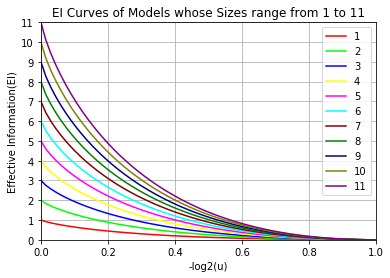

In [12]:
Derive_EI_diagrams(Sizes, x, EIs)

### Calculate the CE Absolute Thresholds (ATs) 

In [13]:
origin_sizes = np.linspace(3, 11, 9).astype(np.int64)
target_sizes = np.linspace(2, 10, 9).astype(np.int64)

In [11]:
#Collect the EI curves for original models with the changing uncertainty and the straight line for the maximum EI of target models
#Save the single maximum values for computing the Absolute CE Threshold
def EIs_Computations(origin_sizes, target_sizes):
    origin_uncertainty = np.linspace(1, 0.5, 51) #initialzation: continuous uncertainty to derive the EI curves of original models
    target_uncertainty = np.ones(51) #initialization: fixed uncertainty(=1, means no uncertainty) to derive the maximum values of target models
    
    #calculate the EI curves of original models with the changing uncertainties
    origin_EI_group = [] #Save the EI of every size to a group
    for i in range(len(origin_sizes)):
        EI_current_size = [] #Save the EI of current size but with different uncertainty to a group
        for j in range(len(origin_uncertainty)):
            final_TPMs = retrodict_TPM(origin_sizes[i],origin_uncertainty[j], 1, 1) #Load all possible TPMs in the current size and uncertainty but without the degeneracy
            determinism, degeneracy, EI = EI_Calculator(origin_sizes[i], final_TPMs[0])
            EI_current_size.append(EI)
        origin_EI_group.append(np.array(EI_current_size))
    
    #Calculate the straight line to illustrate the maximum EI of target models with the fixed uncertainties
    target_EI_group = [] #Save the EI of every size to a group
    maximum_EI_group = [] # Save the maximum EI values for calculating the Absolute Thresholds
    for i in range(len(target_sizes)):
        EI_current_size = [] #Save the EI of current size but with different uncertainty to a group
        for j in range(len(target_uncertainty)):
            final_TPMs = retrodict_TPM(target_sizes[i],target_uncertainty[j], 1, 1) #Load all possible TPMs in the current size and uncertainty but without the degeneracy
            determinism, degeneracy, EI = EI_Calculator(target_sizes[i], final_TPMs[0])
            EI_current_size.append(EI)
        maximum_EI_group.append(np.array(EI_current_size[0]))
        target_EI_group.append(np.array(EI_current_size))
    
    return np.array(origin_EI_group), np.array(target_EI_group), np.array(maximum_EI_group)

In [31]:
#This is a general blocks to compute the result of quantification equations
def equation_solver(model_size, equa_constant):
    #two inputs here are respectively the constant items contained by the equation.
    #the model_size is for n
    #the equa_constant is for the right items of the equation. e.g. equa_constant = 1 for calculating the thresholds that coarse-grain to n=1
    T_c = 1e-06 #initialization: A cut-off threshold to stop the algorithm and save the approximate result.
    i = 1 #initialization: An index to choose which decimal place of thhe solution needs to be added 1
    x = 0.1 #initialization: A initial solution of the equation
    while np.absolute((1+(1-2**(-x))*np.log2(1-2**(-x))+(2**(-x))*np.log2(2**(-x))) - (equa_constant/model_size)) > T_c:
        if (1 + (1-2**(-x)) * np.log2(1-2**(-x)) + (2**(-x)) * np.log2(2**(-x))) - (equa_constant/model_size) > T_c:
            x += 10**(-i)
        if (equa_constant/model_size) - (1+(1-2**(-x))*np.log2(1-2**(-x))+(2**(-x))*np.log2(2**(-x))) > T_c:
            x -= 10**(-i)
            i += 1
            x += 10**(-i)
    result = x
    return result

In [13]:
#derive the Absolute Thresholds for the specific original model and its possible target models
def Thres_Computations(original_model_size, target_sizes, maximum_EIs):
    #searching the gtoup of target sizes to derive all possible target models' sizes for this coarse-graining operation
    size_index = 0 #initialization: An index to stop the searching
    while target_sizes[size_index] < original_model_size:
        size_index += 1
        if size_index == 9:
            break
    if size_index == 9:
        possible_targets = maximum_EIs
    else:
        possible_targets = maximum_EIs[0: size_index] #save EIs of all possible target models as the inputs of the equation-solving algorithm
    
    #put the possible EIs to the equation solver as the values of equa_constant respectively to calculate the Absolute Thresholds.
    Absolute_Thresholds = [] #initialize a group to save the values of absolute thresholds
    for solve_index in range(size_index):
        A_threshold = equation_solver(original_model_size, possible_targets[solve_index])
        Absolute_Thresholds.append(A_threshold)
    return size_index, Absolute_Thresholds

In [17]:
origin_EIs, target_EIs, maximum_EIs = EIs_Computations(origin_sizes, target_sizes) #Derive the EI curves and lines

In [18]:
print(origin_EIs[7])
print(target_EIs[0])

[1.00000000e+01 9.19206864e+00 8.58559457e+00 8.05608142e+00
 7.57707811e+00 7.13603043e+00 6.72555081e+00 6.34076349e+00
 5.97820810e+00 5.63530183e+00 5.31004406e+00 5.00084042e+00
 4.70639135e+00 4.42561815e+00 4.15761188e+00 3.90159695e+00
 3.65690445e+00 3.42295221e+00 3.19922954e+00 2.98528540e+00
 2.78071905e+00 2.58517260e+00 2.39832497e+00 2.21988696e+00
 2.04959721e+00 1.88721876e+00 1.73253628e+00 1.58535364e+00
 1.44549189e+00 1.31278754e+00 1.18709101e+00 1.06826542e+00
 9.56185423e-01 8.50736272e-01 7.51812950e-01 6.59319446e-01
 5.73168107e-01 4.93279073e-01 4.19579778e-01 3.52004515e-01
 2.90494055e-01 2.34995312e-01 1.85461050e-01 1.41849628e-01
 1.04124788e-01 7.22554601e-02 4.62156118e-02 2.59841143e-02
 1.15446400e-02 2.88558247e-03 0.00000000e+00]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2.]


In [19]:
line_for_3, A_thres_for_3 = Thres_Computations(origin_sizes[0], target_sizes, maximum_EIs)
line_for_4, A_thres_for_4 = Thres_Computations(origin_sizes[1], target_sizes, maximum_EIs)
line_for_5, A_thres_for_5 = Thres_Computations(origin_sizes[2], target_sizes, maximum_EIs)
line_for_6, A_thres_for_6 = Thres_Computations(origin_sizes[3], target_sizes, maximum_EIs)
line_for_7, A_thres_for_7 = Thres_Computations(origin_sizes[4], target_sizes, maximum_EIs)
line_for_8, A_thres_for_8 = Thres_Computations(origin_sizes[5], target_sizes, maximum_EIs)
line_for_9, A_thres_for_9 = Thres_Computations(origin_sizes[6], target_sizes, maximum_EIs)
line_for_10, A_thres_for_10 = Thres_Computations(origin_sizes[7], target_sizes, maximum_EIs)
line_for_11, A_thres_for_11 = Thres_Computations(origin_sizes[8], target_sizes, maximum_EIs)
print(A_thres_for_11)
print(len(A_thres_for_11))

[0.423531, 0.32678399999999996, 0.2530169999999999, 0.19375700000000004, 0.14479700000000004, 0.10374900000000002, 0.06917799999999999, 0.04026510000000003, 0.016761599999999995]
9


In [20]:
x = np.linspace(1, 0.5, 51) #The continuously changing uncertainty to derive the EI curves of the original model

<Figure size 432x288 with 0 Axes>

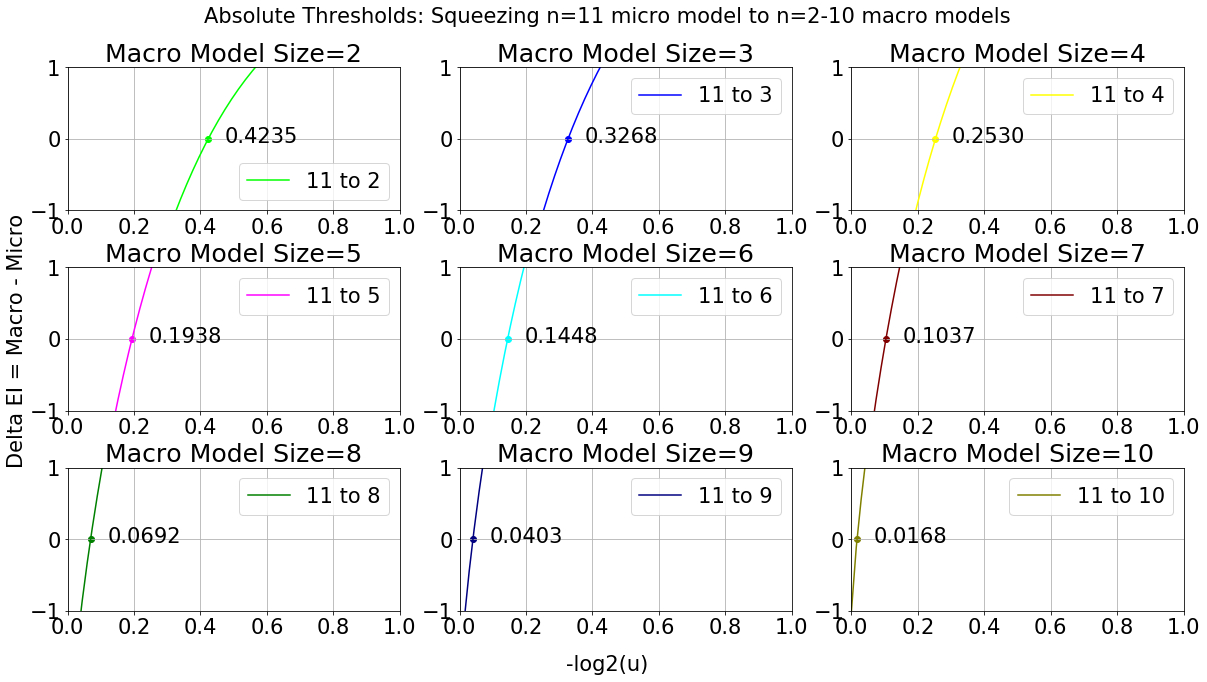

In [21]:
savePath = r'D:\Projects\Causal_Emergence\Drafts\Formal Submission\for Hindawi Complexity\Figures_result1'
name = 'Absolute_Thresholds_Micro_Model_Size_is_11.png'

plt.figure(facecolor = 'white')
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.rcParams['font.size'] = 21
fig.text(0.5, 0.95, 'Absolute Thresholds: Squeezing n=11 micro model to n=2-10 macro models', ha='center', va='center')
fig.text(0.5, 0.05, '-log2(u)', ha='center', va='center')
fig.text(0.09, 0.5, 'Delta EI = Macro - Micro', ha='center', va='center', rotation='vertical')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.18, hspace=0.4)
plt.subplot(3, 3, 1)
Delta_EI_11_2 = target_EIs[0] - origin_EIs[8]
plt.plot(-np.log2(x), Delta_EI_11_2, color='#00FF00', label = '11 to 2')
plt.scatter(A_thres_for_11[0], 0, c='#00FF00')
plt.annotate(format(A_thres_for_11[0], '.4f'), xy=(A_thres_for_11[0], 0), xytext=(A_thres_for_11[0] + 0.05, -0.05))
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.title('Macro Model Size=2')
plt.grid()
plt.legend()

plt.subplot(3, 3, 2)
Delta_EI_11_3 = target_EIs[1] - origin_EIs[8]
plt.plot(-np.log2(x), Delta_EI_11_3, color='#0000FF', label = '11 to 3')
plt.scatter(A_thres_for_11[1], 0, c='#0000FF')
plt.annotate(format(A_thres_for_11[1], '.4f'), xy=(A_thres_for_11[1], 0), xytext=(A_thres_for_11[1] + 0.05, -0.05))
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.title('Macro Model Size=3')
plt.grid()
plt.legend()

plt.subplot(3, 3, 3)
Delta_EI_11_4 = target_EIs[2] - origin_EIs[8]
plt.plot(-np.log2(x), Delta_EI_11_4, color='#FFFF00', label = '11 to 4')
plt.scatter(A_thres_for_11[2], 0, c='#FFFF00')
plt.annotate(format(A_thres_for_11[2], '.4f'), xy=(A_thres_for_11[2], 0), xytext=(A_thres_for_11[2] + 0.05, -0.05))
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.title('Macro Model Size=4')
plt.grid()
plt.legend()

plt.subplot(3, 3, 4)
Delta_EI_11_5 = target_EIs[3] - origin_EIs[8]
plt.plot(-np.log2(x), Delta_EI_11_5, color='#FF00FF', label = '11 to 5')
plt.scatter(A_thres_for_11[3], 0, c='#FF00FF')
plt.annotate(format(A_thres_for_11[3], '.4f'), xy=(A_thres_for_11[3], 0), xytext=(A_thres_for_11[3] + 0.05, -0.05))
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.title('Macro Model Size=5')
plt.grid()
plt.legend()

plt.subplot(3, 3, 5)
Delta_EI_11_6 = target_EIs[4] - origin_EIs[8]
plt.plot(-np.log2(x), Delta_EI_11_6, color='#00FFFF', label = '11 to 6')
plt.scatter(A_thres_for_11[4], 0, c='#00FFFF')
plt.annotate(format(A_thres_for_11[4], '.4f'), xy=(A_thres_for_11[4], 0), xytext=(A_thres_for_11[4] + 0.05, -0.05))
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.title('Macro Model Size=6')
plt.grid()
plt.legend()

plt.subplot(3, 3, 6)
Delta_EI_11_7 = target_EIs[5] - origin_EIs[8]
plt.plot(-np.log2(x), Delta_EI_11_7, color='#800000', label = '11 to 7')
plt.scatter(A_thres_for_11[5], 0, c='#800000')
plt.annotate(format(A_thres_for_11[5], '.4f'), xy=(A_thres_for_11[5], 0), xytext=(A_thres_for_11[5] + 0.05, -0.05))
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.title('Macro Model Size=7')
plt.grid()
plt.legend()

plt.subplot(3, 3, 7)
Delta_EI_11_8 = target_EIs[6] - origin_EIs[8]
plt.plot(-np.log2(x), Delta_EI_11_8, color='#008000', label = '11 to 8')
plt.scatter(A_thres_for_11[6], 0, c='#008000')
plt.annotate(format(A_thres_for_11[6], '.4f'), xy=(A_thres_for_11[6], 0), xytext=(A_thres_for_11[6] + 0.05, -0.05))
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.title('Macro Model Size=8')
plt.grid()
plt.legend()

plt.subplot(3, 3, 8)
Delta_EI_11_9 = target_EIs[7] - origin_EIs[8]
plt.plot(-np.log2(x), Delta_EI_11_9, color='#000080', label = '11 to 9')
plt.scatter(A_thres_for_11[7], 0, c='#000080')
plt.annotate(format(A_thres_for_11[7], '.4f'), xy=(A_thres_for_11[7], 0), xytext=(A_thres_for_11[7] + 0.05, -0.05))
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.title('Macro Model Size=9')
plt.grid()
plt.legend()

plt.subplot(3, 3, 9)
Delta_EI_11_10 = target_EIs[8] - origin_EIs[8]
plt.plot(-np.log2(x), Delta_EI_11_10, color='#808000', label = '11 to 10')
plt.scatter(A_thres_for_11[8], 0, c='#808000')
plt.annotate(format(A_thres_for_11[8], '.4f'), xy=(A_thres_for_11[8], 0), xytext=(A_thres_for_11[8] + 0.05, -0.05))
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.title('Macro Model Size=10')
plt.grid()
plt.legend()

plt.savefig(os.path.join(savePath, name))
plt.show()

### Calculate all absolute thresholds displayed in Table 1

In [22]:
origin_sizes = np.linspace(2, 11, 10).astype(np.int64)
target_sizes = np.linspace(1, 10, 10).astype(np.int64)

ATs = {'11': [], '10': [], '9': [], '8': [], '7': [], '6': [], '5': [], '4': [], '3': [], '2': []}
for model_size in origin_sizes:
    for target in target_sizes:
        if target >= model_size:
            break
        at = equation_solver(model_size, target)
        ATs[str(model_size)].append(at)

for k, v in ATs.items():
    print('Absolute Thresholds:')
    print(f'{k}: {v}')

Absolute Thresholds:
11: [0.565734, 0.423531, 0.32678399999999996, 0.2530169999999999, 0.19375700000000004, 0.14479700000000004, 0.10374900000000002, 0.06917799999999999, 0.04026510000000003, 0.016761599999999995]
Absolute Thresholds:
10: [0.5479709999999997, 0.40164099999999997, 0.30275599999999986, 0.22786500000000004, 0.1681680000000001, 0.11932600000000002, 0.07892800000000004, 0.04561700000000003, 0.018859000000000008]
Absolute Thresholds:
9: [0.5276729999999997, 0.3768179999999998, 0.2757029999999999, 0.19977700000000007, 0.139878, 0.091557, 0.052448000000000036, 0.021501599999999992]
Absolute Thresholds:
8: [0.5041529999999999, 0.3483200000000001, 0.24492799999999998, 0.1681680000000001, 0.10850300000000003, 0.06144000000000003, 0.024925299999999997]
Absolute Thresholds:
7: [0.4764300000000001, 0.31511100000000003, 0.2094990000000001, 0.132338, 0.07375700000000002, 0.02951820000000001]
Absolute Thresholds:
6: [0.44303200000000004, 0.2757029999999999, 0.1681680000000001, 0.091557

### Calculate Equivalent Thresholds (ETs)

In [23]:
origin_size = 11
target_sizes = np.linspace(2, 10, 9).astype(np.int64)

In [14]:
#Collect the EI curves for original models with the changing uncertainty and the straight line for the maximum EI of target models
#Save the single maximum values for computing the Absolute CE Threshold
def EIs_Computations(origin_sizes, target_sizes):
    origin_uncertainty = np.linspace(1, 0.5, 101) #initialzation: continuous uncertainty to derive the EI curves of original models
    target_uncertainty = np.ones(51) #initialization: fixed uncertainty(=1, means no uncertainty) to derive the maximum values of target models
    
    #calculate the EI curves of original models with the changing uncertainties
    origin_EI_group = [] #Save the EI of every size to a group
    for i in range(len(origin_sizes)):
        EI_current_size = [] #Save the EI of current size but with different uncertainty to a group
        for j in range(len(origin_uncertainty)):
            final_TPMs = retrodict_TPM(origin_sizes[i],origin_uncertainty[j], 1, 1) #Load all possible TPMs in the current size and uncertainty but without the degeneracy
            determinism, degeneracy, EI = EI_Calculator(origin_sizes[i], final_TPMs[0])
            EI_current_size.append(EI)
        origin_EI_group.append(np.array(EI_current_size))
    
    #Calculate the straight line to illustrate the maximum EI of target models with the fixed uncertainties
    target_EI_group = [] #Save the EI of every size to a group
    maximum_EI_group = [] # Save the maximum EI values for calculating the Absolute Thresholds
    for i in range(len(target_sizes)):
        EI_current_size = [] #Save the EI of current size but with different uncertainty to a group
        for j in range(len(target_uncertainty)):
            final_TPMs = retrodict_TPM(target_sizes[i],target_uncertainty[j], 1, 1) #Load all possible TPMs in the current size and uncertainty but without the degeneracy
            determinism, degeneracy, EI = EI_Calculator(target_sizes[i], final_TPMs[0])
            EI_current_size.append(EI)
        maximum_EI_group.append(np.array(EI_current_size[0]))
        target_EI_group.append(np.array(EI_current_size))
    
    return np.array(origin_EI_group), np.array(target_EI_group), np.array(maximum_EI_group)

In [29]:
origin_EIs, _, _ = EIs_Computations([origin_size], target_sizes)

In [44]:
ETs = {'2': [], '3': [], '4': [], '5':[], '6': [], '7': [], '8': [], '9': [], '10': []}
for size in target_sizes:
    for EI in origin_EIs[0]:
        if EI > size:
            continue
        et = equation_solver(size, EI)
        ETs[str(size)].append(et)
for i in range(2, 11):
    print(len(ETs[str(i)]))
print(len(origin_EIs[0]))
print(len(origin_EIs[0][-len(ETs['2']):]))

50
60
68
75
81
87
91
95
98
101
50


<Figure size 432x288 with 0 Axes>

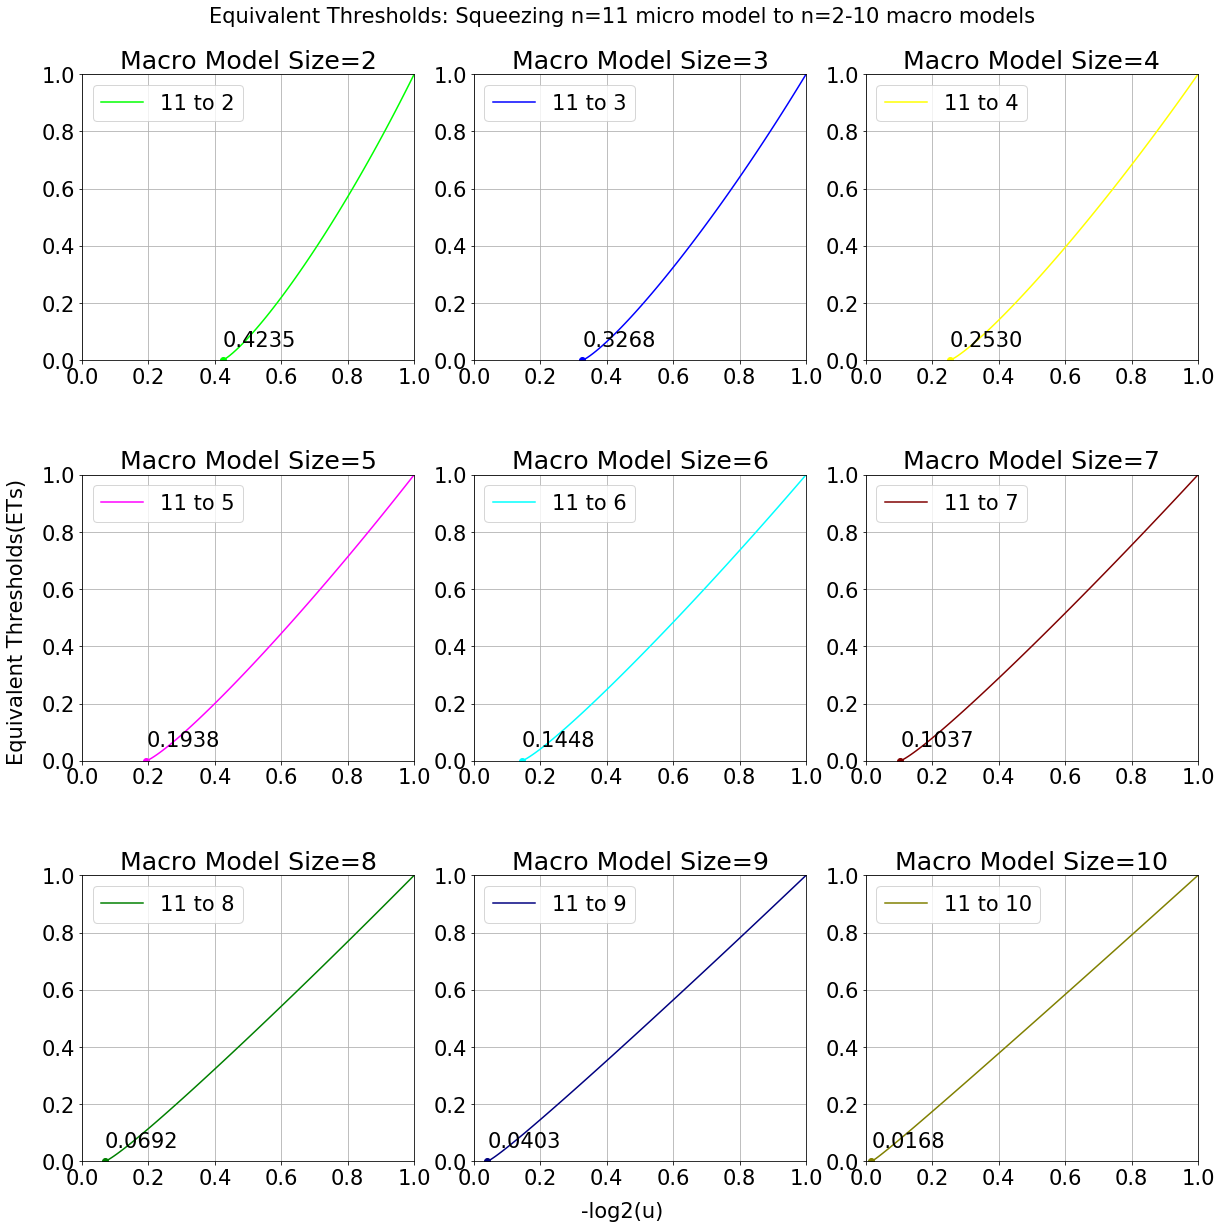

In [58]:
savePath = r'D:\Projects\Causal_Emergence\Drafts\Formal Submission\for Hindawi Complexity\Figures_result1'
name = 'Equivalent_Thresholds_Micro_Model_Size_is_11.png'

x = np.linspace(1, 0.5, 101)

plt.figure(facecolor = 'white')
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
plt.rcParams['font.size'] = 21
fig.text(0.5, 0.92, 'Equivalent Thresholds: Squeezing n=11 micro model to n=2-10 macro models', ha='center', va='center')
fig.text(0.5, 0.09, '-log2(u)', ha='center', va='center')
fig.text(0.08, 0.5, 'Equivalent Thresholds(ETs)', ha='center', va='center', rotation='vertical')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.18, hspace=0.4)
plt.subplot(3, 3, 1)
u1 = x[-len(ETs['2']):]
plt.plot(-np.log2(u1), ETs['2'], color='#00FF00', label = '11 to 2')
plt.scatter(A_thres_for_11[0], 0, c='#00FF00')
plt.annotate(format(A_thres_for_11[0], '.4f'), xy=(A_thres_for_11[0], 0), xytext=(A_thres_for_11[0], 0.05))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Macro Model Size=2')
plt.grid()
plt.legend()

plt.subplot(3, 3, 2)
u2 = x[-len(ETs['3']):]
plt.plot(-np.log2(u2), ETs['3'], color='#0000FF', label = '11 to 3')
plt.scatter(A_thres_for_11[1], 0, c='#0000FF')
plt.annotate(format(A_thres_for_11[1], '.4f'), xy=(A_thres_for_11[1], 0), xytext=(A_thres_for_11[1], 0.05))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Macro Model Size=3')
plt.grid()
plt.legend()

plt.subplot(3, 3, 3)
u3 = x[-len(ETs['4']):]
plt.plot(-np.log2(u3), ETs['4'], color='#FFFF00', label = '11 to 4')
plt.scatter(A_thres_for_11[2], 0, c='#FFFF00')
plt.annotate(format(A_thres_for_11[2], '.4f'), xy=(A_thres_for_11[2], 0), xytext=(A_thres_for_11[2], 0.05))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Macro Model Size=4')
plt.grid()
plt.legend()

plt.subplot(3, 3, 4)
u4 = x[-len(ETs['5']):]
plt.plot(-np.log2(u4), ETs['5'], color='#FF00FF', label = '11 to 5')
plt.scatter(A_thres_for_11[3], 0, c='#FF00FF')
plt.annotate(format(A_thres_for_11[3], '.4f'), xy=(A_thres_for_11[3], 0), xytext=(A_thres_for_11[3], 0.05))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Macro Model Size=5')
plt.grid()
plt.legend()

plt.subplot(3, 3, 5)
u5 = x[-len(ETs['6']):]
plt.plot(-np.log2(u5), ETs['6'], color='#00FFFF', label = '11 to 6')
plt.scatter(A_thres_for_11[4], 0, c='#00FFFF')
plt.annotate(format(A_thres_for_11[4], '.4f'), xy=(A_thres_for_11[4], 0), xytext=(A_thres_for_11[4], 0.05))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Macro Model Size=6')
plt.grid()
plt.legend()

plt.subplot(3, 3, 6)
u6 = x[-len(ETs['7']):]
plt.plot(-np.log2(u6), ETs['7'], color='#800000', label = '11 to 7')
plt.scatter(A_thres_for_11[5], 0, c='#800000')
plt.annotate(format(A_thres_for_11[5], '.4f'), xy=(A_thres_for_11[5], 0), xytext=(A_thres_for_11[5], 0.05))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Macro Model Size=7')
plt.grid()
plt.legend()

plt.subplot(3, 3, 7)
u7 = x[-len(ETs['8']):]
plt.plot(-np.log2(u7), ETs['8'], color='#008000', label = '11 to 8')
plt.scatter(A_thres_for_11[6], 0, c='#008000')
plt.annotate(format(A_thres_for_11[6], '.4f'), xy=(A_thres_for_11[6], 0), xytext=(A_thres_for_11[6], 0.05))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Macro Model Size=8')
plt.grid()
plt.legend()

plt.subplot(3, 3, 8)
u8 = x[-len(ETs['9']):]
plt.plot(-np.log2(u8), ETs['9'], color='#000080', label = '11 to 9')
plt.scatter(A_thres_for_11[7], 0, c='#000080')
plt.annotate(format(A_thres_for_11[7], '.4f'), xy=(A_thres_for_11[7], 0), xytext=(A_thres_for_11[7], 0.05))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Macro Model Size=9')
plt.grid()
plt.legend()

plt.subplot(3, 3, 9)
u9 = x[-len(ETs['10']):]
plt.plot(-np.log2(u9), ETs['10'], color='#808000', label = '11 to 10')
plt.scatter(A_thres_for_11[8], 0, c='#808000')
plt.annotate(format(A_thres_for_11[8], '.4f'), xy=(A_thres_for_11[8], 0), xytext=(A_thres_for_11[8], 0.05))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Macro Model Size=10')
plt.grid()
plt.legend()

plt.savefig(os.path.join(savePath, name))
plt.show()

### Zoom twenty times in the "Macro Model Size=10" subfigure's region from 0.8 to 0.9

[0.87567186 0.88896869 0.9023892  0.91593574 0.92961067 0.94341647
 0.95735566 0.97143085 0.98564471 1.        ]
[0.8698699999999996, 0.8837599999999997, 0.8977999999999999, 0.9119499999999996, 0.9262499999999997, 0.9406999999999999, 0.9552999999999999, 0.9700099999999999, 0.985, 0.9999999999999999]


<Figure size 432x288 with 0 Axes>

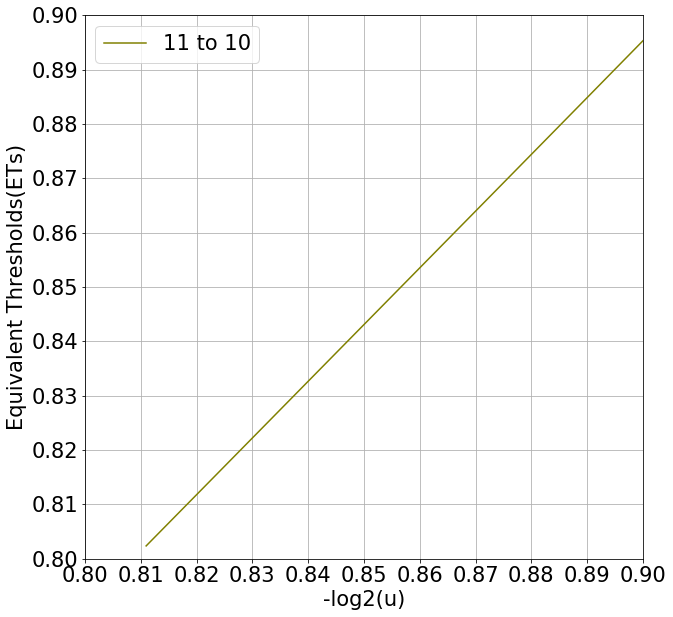

In [78]:
savePath = r"D:\Projects\Causal_Emergence\Drafts\Formal Submission\for Hindawi Complexity\Figures_method"
    
name = 'Zoom_ten_times_in_8_to_9_region_of_Macro_Model_size_10_subfigure.png'

index = 0
for Et in ETs['10']:
    if Et < 0.8:
        continue
    else:
        index = ETs['10'].index(Et)
        break
u = u9[index:]
ET = ETs['10'][index:]
print(-np.log2(u)[-10:])
print(ET[-10:])

plt.figure(facecolor = 'white')
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

plt.plot(-np.log2(u), ET, color = '#808000', label = '11 to 10')

plt.xticks(np.arange(0.8, 1.2, 0.01).astype(np.float64))
plt.yticks(np.arange(0.8, 1.2, 0.01).astype(np.float64))
plt.xlim(0.8, 0.9)
plt.ylim(0.8, 0.9)
plt.xlabel("-log2(u)")
plt.ylabel("Equivalent Thresholds(ETs)")
plt.legend()
plt.grid()
plt.savefig(os.path.join(savePath, name))
plt.show()

### Calculate the micro uncertainty when ET = 0.99

In [82]:
calculator = Controllable_EI(n=10, deg_vector=[1, 1], u=2**(-0.99))
_, _, target_EI = calculator()
u_micro = equation_solver(11, target_EI[0])
print(u_micro)

for the parameter settings, here are 1 of TPMs generated.
The values of EIs of your artificial TPMs are: [0.0003489884115235212]
0.9904


### Zoom twenty times in the "Macro Model Size=10" subfigure's region from 0.9 to 1.0

[0.87567186 0.88896869 0.9023892  0.91593574 0.92961067 0.94341647
 0.95735566 0.97143085 0.98564471 1.        ]
[0.8698699999999996, 0.8837599999999997, 0.8977999999999999, 0.9119499999999996, 0.9262499999999997, 0.9406999999999999, 0.9552999999999999, 0.9700099999999999, 0.985, 0.9999999999999999]


<Figure size 432x288 with 0 Axes>

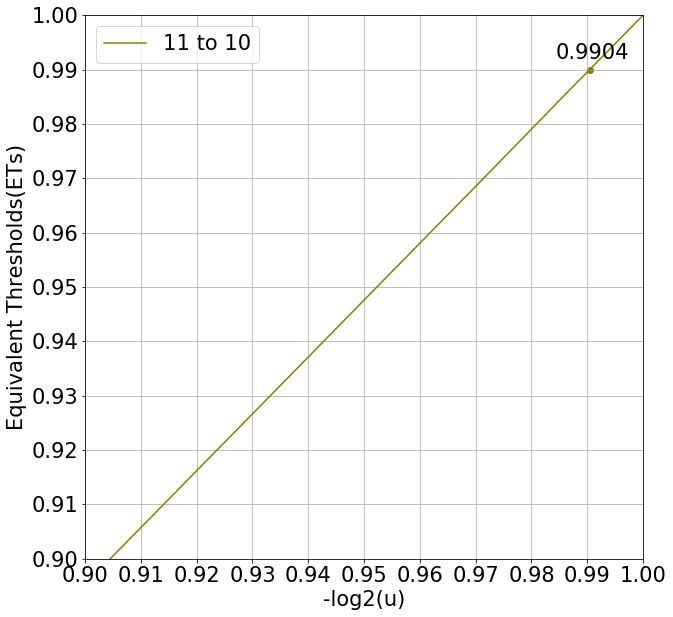

In [90]:
savePath = r"D:\Projects\Causal_Emergence\Drafts\Formal Submission\for Hindawi Complexity\Figures_method"
    
name = 'Zoom_ten_times_in_9_to_10_region_of_Macro_Model_size_10_subfigure.png'

index = 0
for Et in ETs['10']:
    if Et < 0.8:
        continue
    else:
        index = ETs['10'].index(Et)
        break
u = u9[index:]
ET = ETs['10'][index:]
print(-np.log2(u)[-10:])
print(ET[-10:])

plt.figure(facecolor = 'white')
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

plt.plot(-np.log2(u), ET, color = '#808000', label = '11 to 10')
plt.scatter(u_micro, 0.99, c='#808000')
plt.annotate(format(u_micro, '.4f'), xy=(u_micro, 0.99), xytext=(u_micro - 0.006, 0.992))
plt.xticks(np.arange(0.8, 1.2, 0.01).astype(np.float64))
plt.yticks(np.arange(0.8, 1.2, 0.01).astype(np.float64))
plt.xlim(0.9, 1)
plt.ylim(0.9, 1)
plt.xlabel("-log2(u)")
plt.ylabel("Equivalent Thresholds(ETs)")
plt.legend()
plt.grid()
plt.savefig(os.path.join(savePath, name))
plt.show()

### Degeneracy_Influences

In [12]:
#Derive the group of degeneracy to plot the Degeneracy curves changing with the uncertainty
def Collect_deg(size):
    degenerate_level = np.linspace(2, 2**size, 2**size-1)
    uncertainty = np.linspace(1, 0.5, 51) #initialzation: vector to continuously change model's degeneracy and uncertainty
    det_group = [] #Save the Degterminism under current definition but with different uncertainty to a group
    deg_group = [] #Save the Degeneracy under current definition but with different uncertainty to a group
    for i in range(len(degenerate_level)):
        det_current_def = [] #Save the Determinism under the special definition which is selected
        deg_current_def = [] #Save the Degeneracy under the special definition which is selected
        for j in range(len(uncertainty)):
            final_TPMs = retrodict_TPM(size, uncertainty[j], 1, degenerate_level[i])
            determinism, degeneracy, EI = EI_Calculator(size, final_TPMs[0])
            det_current_def.append(determinism)
            deg_current_def.append(degeneracy)
        det_group.append(np.array(det_current_def))
        deg_group.append(np.array(deg_current_def))
    return uncertainty, np.array(det_group), np.array(deg_group)

In [13]:
#A block to compute the degeneracy value of the defined model
def Degeneracy_Calculator(n, TPM):
    #Initialization: Intervention Distribution, I_D = Maximum Entropy Distribution, H_max, Entropy of Intervention Distribution, H_I
    I_D = H_max = np.ones(2**n)/(2**n)
    H_I = - np.log2(1/(2**n))
    #Calculate the mean of effect distribution, U_D, from the TPM
    U_D = np.sum(TPM, axis = 0)/(2**n)
    
    #Calculate the mean of KL Divergence to derive the degeneracy value of the model
    D_KL_mean = 0
    for i in range(len(U_D)):
        if U_D[i] == 0:
            continue
        else:
            D_KL_mean += U_D[i] * np.log2(U_D[i]/I_D[i])
    #With the mean of KL divergence, calculate the value of degeneracy
    deg = D_KL_mean/n
    return deg

In [14]:
#Collect the degeneracy values for fifty uncertainties
def collect_Deg(x, future_dg_num, dg_level):
    deg_group = [] #Save the EI of every size to a group
    for i in range(len(x)):
        final_TPMs = retrodict_TPM(3, x[i], future_dg_num, dg_level) #Load all possible TPMs in the current size and uncertainty but without the degeneracy
        deg = Degeneracy_Calculator(3, final_TPMs[0])
        deg_group.append(deg)
    return np.array(deg_group)

In [15]:
#Collect the EI curve of the targeted model
def collect_Target(n, x):
    EI_group = []
    for i in range(len(x)):
        EI = n * (1 + (1-x[i]) * np.log2(1-x[i]) + x[i] * np.log2(x[i]))
        EI_group.append(EI)
    return np.array(EI_group)

In [42]:
#Plot the thresholds of mapping degenerate n=3 model to n=2 deterministic model
x = np.linspace(1, 0.5, 51)
savePath = r'D:\Projects\Causal_Emergence\Drafts\Formal Submission\for Hindawi Complexity\Figures_result1'
name = 'Degeneracy_Influences_Absolute_and_Equivalent_Thresholds.png'

#derive the EI Curves
EI_max = collect_Target(3, x)
EI_max[0] = 3

deg_1 = collect_Deg(x, 1, 2) #0.083
print('[1, 2]:', deg_1)
EI_1 = EI_max - 3 * deg_1 #EI Curves for n=3 models

deg_2 = collect_Deg(x, 1, 3) #0.198
print('[1, 3]:', deg_2)
EI_2 = EI_max - 3 * deg_2 #EI Curves for n=3 models

deg_3 = collect_Deg(x, 1, 4) #0.333
print('[1, 4]:', deg_3)
EI_3 = EI_max - 3 * deg_3 #EI Curves for n=3 models

deg_4 = collect_Deg(x, 1, 5) #0.484
print('[1, 5]:', deg_4)
EI_4 = EI_max - 3 * deg_4 #EI Curves for n=3 models

deg_5 = collect_Deg(x, 1, 6) #0.646
print('[1, 6]:', deg_5)
EI_5 = EI_max - 3 * deg_5 #EI Curves for n=3 models

deg_6 = collect_Deg(x, 1, 7) #0.819
print('[1, 7]:', deg_6)
EI_6 = EI_max - 3 * deg_6 #EI Curves for n=3 models

deg_7 = collect_Deg(x, 2, 4) #0.167
print('[2, 4]:', deg_7)
EI_7 = EI_max - 3 * deg_7 #EI Curves for n=3 models

deg_8 = collect_Deg(x, 2, 5) #0.281
print('[2, 5]:', deg_8)
EI_8 = EI_max - 3 * deg_8 #EI Curves for n=3 models

deg_9 = collect_Deg(x, 2, 6) #0.396
print('[2, 6]:', deg_9)
EI_9 = EI_max - 3 * deg_9 #EI Curves for n=3 models

deg_10 = collect_Deg(x, 2, 7) #0.531
print('[2, 7]:', deg_10)
EI_10 = EI_max - 3 * deg_10 #EI Curves for n=3 models

deg_11 = collect_Deg(x, 2, 8) #0.667
print('[2, 8]:', deg_11)
EI_11 = EI_max - 3 * deg_11 #EI Curves for n=3 models

deg_12 = collect_Deg(x, 3, 6) #0.250
print('[3, 6]:', deg_12)
EI_12 = EI_max - 3 * deg_12 #EI Curves for n=3 models

deg_13 = collect_Deg(x, 3, 7) #0.365
print('[3, 7]:', deg_13)
EI_13 = EI_max - 3 * deg_13 #EI Curves for n=3 models

deg_14 = collect_Deg(x, 3, 8) #0.480
print('[3, 8]:', deg_14)
EI_14 = EI_max - 3 * deg_14 #EI Curves for n=3 models

EI_m = [EI_max, EI_1, EI_2, EI_3, EI_4, EI_5, EI_6]
deg_for_3 = [0, deg_1, deg_2, deg_3, deg_4, deg_5, deg_6]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


[1, 2]: [8.33333333e-02 7.16746350e-02 6.35654699e-02 5.68769703e-02
 5.11371864e-02 4.61139656e-02 4.16658017e-02 3.76960222e-02
 3.41336837e-02 3.09241098e-02 2.80236406e-02 2.53964725e-02
 2.30126349e-02 2.08466303e-02 1.88764834e-02 1.70830545e-02
 1.54495285e-02 1.39610277e-02 1.26043100e-02 1.13675307e-02
 1.02400513e-02 9.21228331e-03 8.27555977e-03 7.42202753e-03
 6.64455672e-03 5.93666360e-03 5.29244433e-03 4.70651775e-03
 4.17397553e-03 3.69033861e-03 3.25151885e-03 2.85378515e-03
 2.49373343e-03 2.16825990e-03 1.87453723e-03 1.60999333e-03
 1.37229229e-03 1.15931737e-03 9.69155802e-04 8.00085179e-04
 6.50561341e-04 5.19207603e-04 4.04805214e-04 3.06284976e-04
 2.22719916e-04 1.53318974e-04 9.74216243e-05 5.44934105e-05
 2.41223311e-05 6.01606445e-06 0.00000000e+00]
[1, 3]: [1.98120313e-01 1.77635869e-01 1.62455023e-01 1.49418801e-01
 1.37837466e-01 1.27375194e-01 1.17828937e-01 1.09060810e-01
 1.00970028e-01 9.34790645e-02 8.65260049e-02 8.00599675e-02
 7.40381865e-02 6.8424

[3, 6]: [2.50000000e-01 2.24686364e-01 2.06308084e-01 1.90659178e-01
 1.76824750e-01 1.64361389e-01 1.53002512e-01 1.42568305e-01
 1.32928342e-01 1.23983163e-01 1.15654098e-01 1.07877182e-01
 1.00599274e-01 9.37754686e-02 8.73672922e-02 8.13414162e-02
 7.56687016e-02 7.03234809e-02 6.52830032e-02 6.05269994e-02
 5.60373351e-02 5.17977294e-02 4.77935243e-02 4.40114935e-02
 4.04396812e-02 3.70672654e-02 3.38844409e-02 3.08823183e-02
 2.80528355e-02 2.53886802e-02 2.28832216e-02 2.05304497e-02
 1.83249208e-02 1.62617091e-02 1.43363628e-02 1.25448649e-02
 1.08835974e-02 9.34930967e-03 7.93908884e-03 6.65033420e-03
 5.48073350e-03 4.42824187e-03 3.49106308e-03 2.66763288e-03
 1.95660432e-03 1.35683509e-03 8.67376629e-04 4.87465060e-04
 2.16513803e-04 5.41079040e-05 0.00000000e+00]
[3, 7]: [3.64786979e-01 3.35926182e-01 3.13880300e-01 2.94494800e-01
 2.76883565e-01 2.60623928e-01 2.45465645e-01 2.31242389e-01
 2.17835189e-01 2.05154492e-01 1.93130303e-01 1.81706317e-01
 1.70836192e-01 1.6048

In [43]:
macro_EI = 2*(1+(1-x)*np.log2(1-x)+x*np.log2(x))
macro_EI[0] = 2

unce1 = 2**(-0.12)
final_TPMs1_2 = retrodict_TPM(3, unce1, 1, 2)
deg1_2 = Degeneracy_Calculator(3, final_TPMs1_2[0])
final_TPMs1_3 = retrodict_TPM(3, unce1, 1, 3)
deg1_3 = Degeneracy_Calculator(3, final_TPMs1_3[0])
final_TPMs1_4 = retrodict_TPM(3, unce1, 1, 4)
deg1_4 = Degeneracy_Calculator(3, final_TPMs1_4[0])
final_TPMs1_5 = retrodict_TPM(3, unce1, 1, 5)
deg1_5 = Degeneracy_Calculator(3, final_TPMs1_5[0])
final_TPMs1_6 = retrodict_TPM(3, unce1, 1, 6)
deg1_6 = Degeneracy_Calculator(3, final_TPMs1_6[0])
final_TPMs1_7 = retrodict_TPM(3, unce1, 1, 7)
deg1_7 = Degeneracy_Calculator(3, final_TPMs1_7[0])
micro_EI1 = 3*(1 + (1-unce1)*np.log2(1-unce1) + unce1*np.log2(unce1))
micro_EI1_2 = micro_EI1 - 3 * deg1_2
micro_EI1_3 = micro_EI1 - 3 * deg1_3
micro_EI1_4 = micro_EI1 - 3 * deg1_4
micro_EI1_5 = micro_EI1 - 3 * deg1_5
micro_EI1_6 = micro_EI1 - 3 * deg1_6
micro_EI1_7 = micro_EI1 - 3 * deg1_7

unce2 = 2**(-0.25)
final_TPMs2_2 = retrodict_TPM(3, unce2, 1, 2)
deg2_2 = Degeneracy_Calculator(3, final_TPMs2_2[0])
final_TPMs2_3 = retrodict_TPM(3, unce2, 1, 3)
deg2_3 = Degeneracy_Calculator(3, final_TPMs2_3[0])
final_TPMs2_4 = retrodict_TPM(3, unce2, 1, 4)
deg2_4 = Degeneracy_Calculator(3, final_TPMs2_4[0])
final_TPMs2_5 = retrodict_TPM(3, unce2, 1, 5)
deg2_5 = Degeneracy_Calculator(3, final_TPMs2_5[0])
final_TPMs2_6 = retrodict_TPM(3, unce2, 1, 6)
deg2_6 = Degeneracy_Calculator(3, final_TPMs2_6[0])
final_TPMs2_7 = retrodict_TPM(3, unce2, 1, 7)
deg2_7 = Degeneracy_Calculator(3, final_TPMs2_7[0])
micro_EI2 = 3*(1 + (1-unce2)*np.log2(1-unce2) + unce2*np.log2(unce2))
micro_EI2_2 = micro_EI2 - 3 * deg2_2
micro_EI2_3 = micro_EI2 - 3 * deg2_3
micro_EI2_4 = micro_EI2 - 3 * deg2_4
micro_EI2_5 = micro_EI2 - 3 * deg2_5
micro_EI2_6 = micro_EI2 - 3 * deg2_6
micro_EI2_7 = micro_EI2 - 3 * deg2_7

unce3 = 2**(-0.42)
final_TPMs3_2 = retrodict_TPM(3, unce3, 1, 2)
deg3_2 = Degeneracy_Calculator(3, final_TPMs3_2[0])
final_TPMs3_3 = retrodict_TPM(3, unce3, 1, 3)
deg3_3 = Degeneracy_Calculator(3, final_TPMs3_3[0])
final_TPMs3_4 = retrodict_TPM(3, unce3, 1, 4)
deg3_4 = Degeneracy_Calculator(3, final_TPMs3_4[0])
final_TPMs3_5 = retrodict_TPM(3, unce3, 1, 5)
deg3_5 = Degeneracy_Calculator(3, final_TPMs3_5[0])
final_TPMs3_6 = retrodict_TPM(3, unce3, 1, 6)
deg3_6 = Degeneracy_Calculator(3, final_TPMs3_6[0])
final_TPMs3_7 = retrodict_TPM(3, unce3, 1, 7)
deg3_7 = Degeneracy_Calculator(3, final_TPMs3_7[0])
micro_EI3 = 3*(1 + (1-unce3)*np.log2(1-unce3) + unce3*np.log2(unce3))
micro_EI3_2 = micro_EI3 - 3 * deg3_2
micro_EI3_3 = micro_EI3 - 3 * deg3_3
micro_EI3_4 = micro_EI3 - 3 * deg3_4
micro_EI3_5 = micro_EI3 - 3 * deg3_5
micro_EI3_6 = micro_EI3 - 3 * deg3_6
micro_EI3_7 = micro_EI3 - 3 * deg3_7

micro_fixed_EI = [[micro_EI1, micro_EI1_2, micro_EI1_3, micro_EI1_4, micro_EI1_5, micro_EI1_6, micro_EI1_7],
                  [micro_EI2, micro_EI2_2, micro_EI2_3, micro_EI2_4, micro_EI2_5, micro_EI2_6, micro_EI2_7],
                  [micro_EI3, micro_EI3_2, micro_EI3_3, micro_EI3_4, micro_EI3_5, micro_EI3_6, micro_EI3_7]]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


In [44]:
def equation_solver_micro(model_size, deg, equa_constant):
    #two inputs here are respectively the constant items contained by the equation.
    #the model_size is for n
    #the equa_constant is for the right items of the equation. e.g. equa_constant = 1 for calculating the thresholds that coarse-grain to n=1
    T_c = 1e-06 #initialization: A cut-off threshold to stop the algorithm and save the approximate result.
    i = 1 #initialization: An index to choose which decimal place of thhe solution needs to be added 1
    x = 0.1 #initialization: A initial solution of the equation
    deg_TPM = retrodict_TPM(model_size, x, 1, deg)
    deg_v = Degeneracy_Calculator(model_size, deg_TPM[0])
    while np.absolute((1+(1-2**(-x))*np.log2(1-2**(-x))+(2**(-x))*np.log2(2**(-x))) - deg_v - (equa_constant/model_size)) > T_c:
        if (1 + (1-2**(-x)) * np.log2(1-2**(-x)) + (2**(-x)) * np.log2(2**(-x))) - deg_v - (equa_constant/model_size) > T_c:
            x += 10**(-i)
            deg_TPM = retrodict_TPM(model_size, x, 1, deg)
            deg_v = Degeneracy_Calculator(model_size, deg_TPM[0])
        if (equa_constant/model_size) - (1+(1-2**(-x))*np.log2(1-2**(-x))+(2**(-x))*np.log2(2**(-x))) + deg_v > T_c:
            x -= 10**(-i)
            i += 1
            x += 10**(-i)
            deg_TPM = retrodict_TPM(model_size, x, 1, deg)
            deg_v = Degeneracy_Calculator(model_size, deg_TPM[0])
    result = x
    return result

In [45]:
deg = [1, 2, 3, 4, 5, 6, 7]
ATs = []
for index, EIs in enumerate(EI_m):
    if EIs[0] >= 2:
        at = equation_solver_micro(3, deg[index], 2)
        ATs.append(at)
    else:
        break
print(ATs)
print(len(ATs))

print(len(micro_fixed_EI[0]), len(micro_fixed_EI[1]), len(micro_fixed_EI[2]))
ETs = [[], [], []]
for i, fixed_EIs in enumerate(micro_fixed_EI):
    for value in fixed_EIs:
        et = equation_solver(2, value)
        ETs[i].append(et)
print(ETs)
print(len(ETs[0]), len(ETs[1]), len(ETs[2]))

[0.091557, 0.07844000000000001, 0.04627000000000003, 1e-07]
4
7 7 7
[[0.019393000000000004, 0.032375300000000044, 0.06276, 0.09894900000000002, 0.15926500000000007, 0.22219400000000014, 0.38866200000000006], [0.14171599999999995, 0.15333700000000003, 0.18446300000000007, 0.2153760000000001, 0.268621, 0.3128069999999998, 0.47358200000000006], [0.3228969999999999, 0.3308179999999998, 0.35648000000000013, 0.379313, 0.42145699999999986, 0.450323, 0.5943649999999999]]
7 7 7


<Figure size 432x288 with 0 Axes>

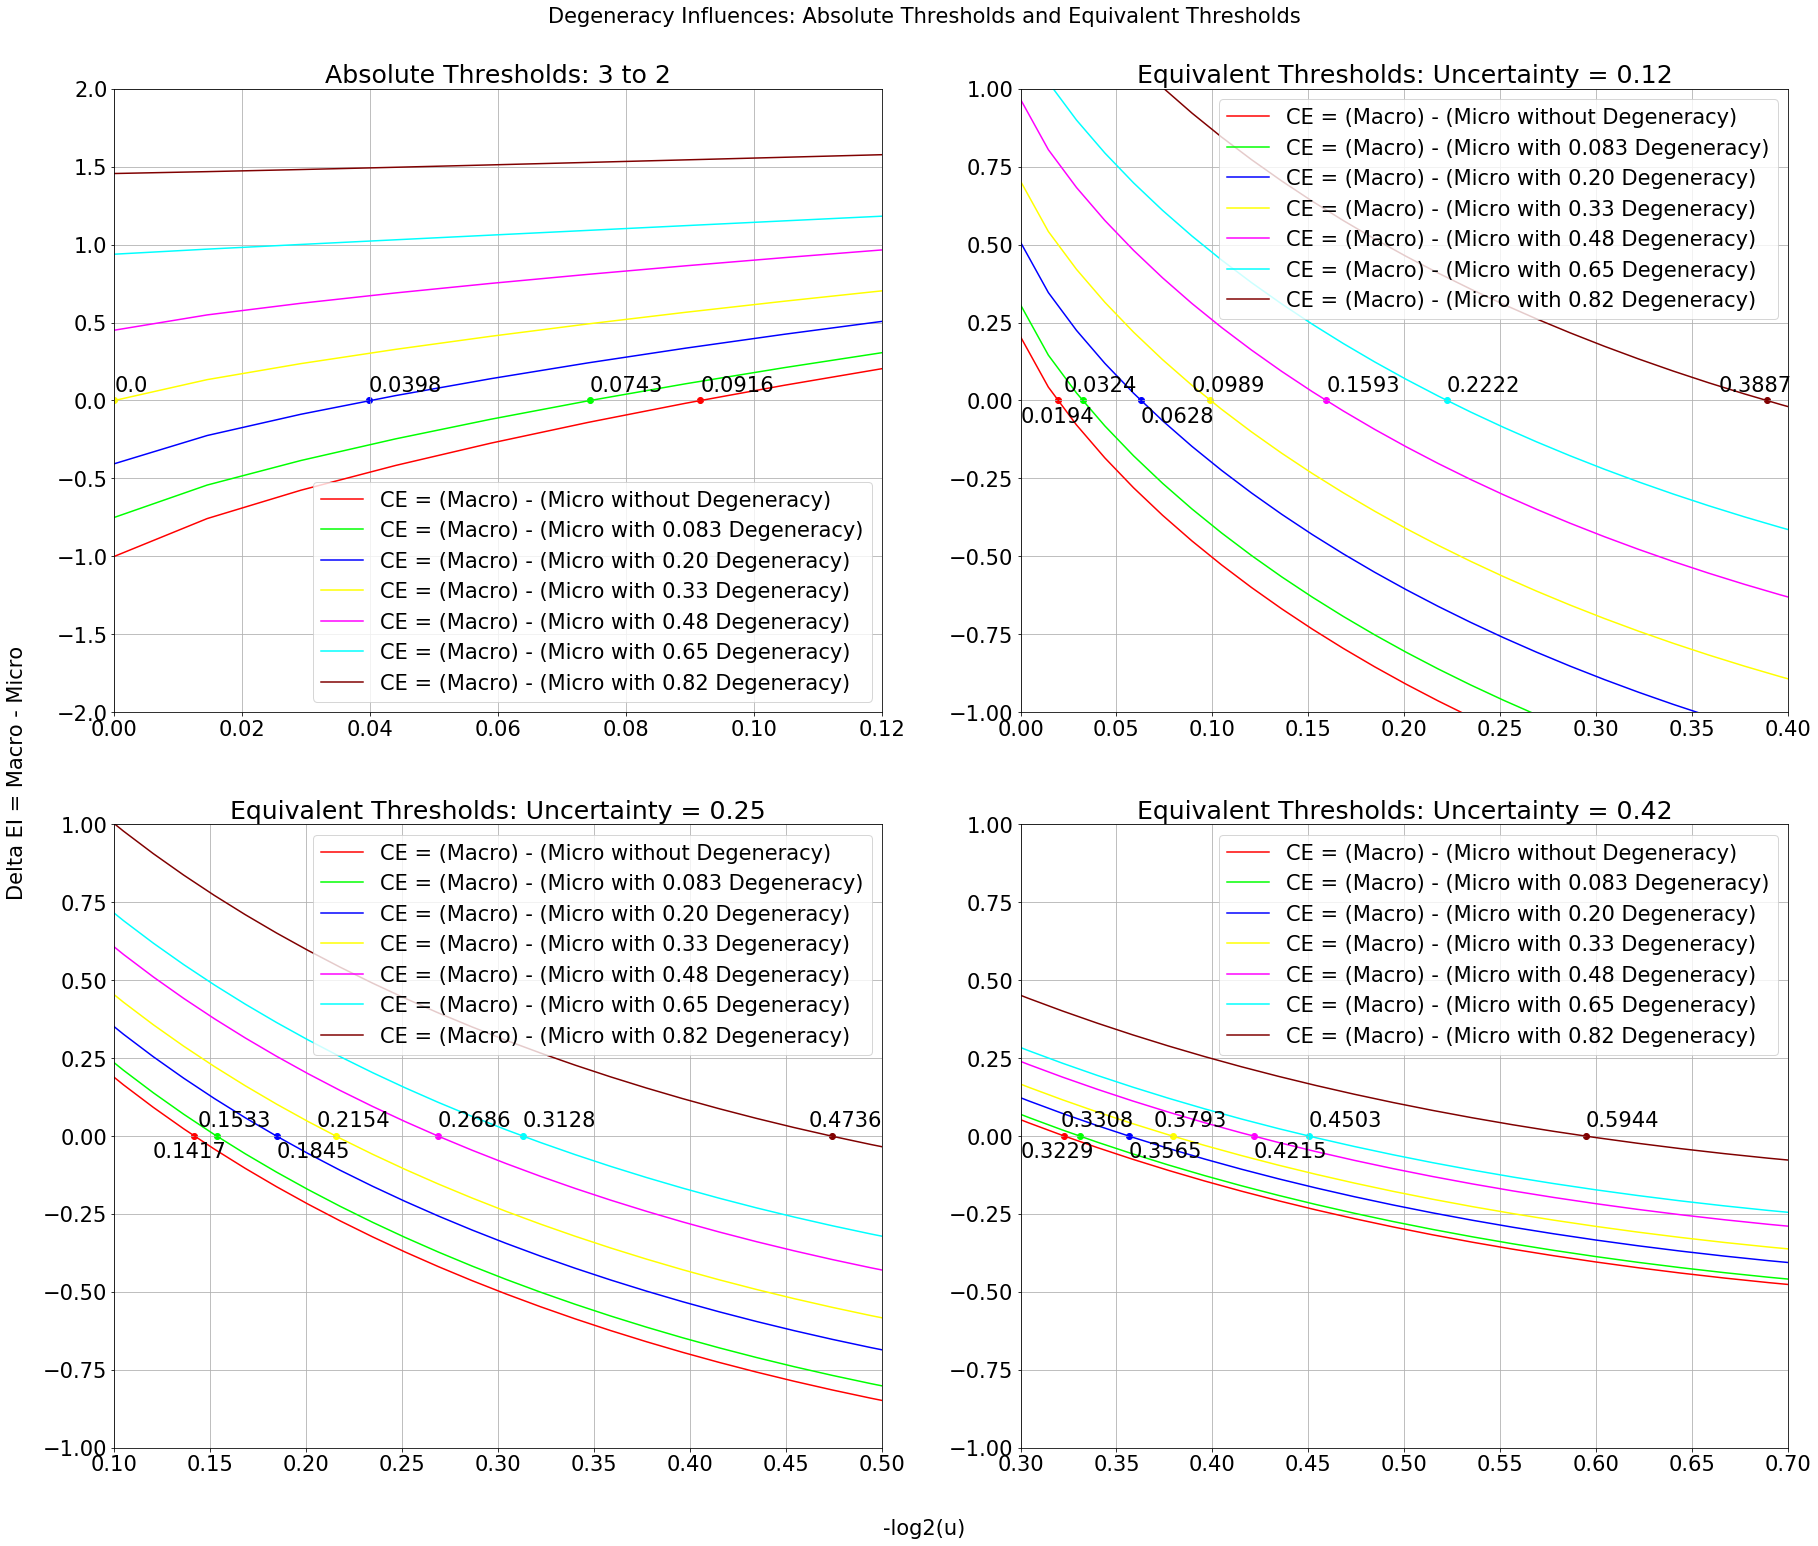

In [109]:
#Plot the Curves and use the straight line to indicate the maximum decreasing of n=3 models
plt.figure(facecolor = 'white')
fig = plt.figure()
fig.set_figheight(25)
fig.set_figwidth(30)
plt.rcParams['font.size'] = 21
fig.text(0.5, 0.92, 'Degeneracy Influences: Absolute Thresholds and Equivalent Thresholds', ha='center', va='center')
fig.text(0.5, 0.08, '-log2(u)', ha='center', va='center')
fig.text(0.08, 0.5, 'Delta EI = Macro - Micro', ha='center', va='center', rotation='vertical')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.18, hspace=0.18)
plt.subplot(2, 2, 1)
plt.plot(-np.log2(x), 2 - EI_max, color='#FF0000', label = 'CE = (Macro) - (Micro without Degeneracy)')
plt.scatter(ATs[0], 0, c='#FF0000')
plt.annotate(format(ATs[0], '.4f'), xy=(ATs[0], 0.06), xytext=(ATs[0], 0.06))

plt.plot(-np.log2(x), 2 - EI_1, color='#00FF00', label = 'CE = (Macro) - (Micro with 0.083 Degeneracy)')
plt.scatter(0.0743, 0, c='#00FF00')
plt.annotate(0.0743, xy=(0.0743, 0.06), xytext=(0.0743, 0.06))

plt.plot(-np.log2(x), 2 - EI_2, color='#0000FF', label = 'CE = (Macro) - (Micro with 0.20 Degeneracy)')
plt.scatter(0.0398, 0, c='#0000FF')
plt.annotate(0.0398, xy=(0.0398, 0.06), xytext=(0.0398, 0.06))

plt.plot(-np.log2(x), 2 - EI_3, color='#FFFF00', label = 'CE = (Macro) - (Micro with 0.33 Degeneracy)')
plt.scatter(0, 0, c='#FFFF00')
plt.annotate(0.0, xy=(0, 0.06), xytext=(0, 0.06))

plt.plot(-np.log2(x), 2 - EI_4, color='#FF00FF', label = 'CE = (Macro) - (Micro with 0.48 Degeneracy)')

plt.plot(-np.log2(x), 2 - EI_5, color='#00FFFF', label = 'CE = (Macro) - (Micro with 0.65 Degeneracy)')

plt.plot(-np.log2(x), 2 - EI_6, color='#800000', label = 'CE = (Macro) - (Micro with 0.82 Degeneracy)')

plt.xlim(0, 0.12)
plt.ylim(-2, 2)
plt.title('Absolute Thresholds: 3 to 2')
plt.grid()
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(-np.log2(x), macro_EI - micro_EI1, color='#FF0000', label = 'CE = (Macro) - (Micro without Degeneracy)')
plt.scatter(ETs[0][0], 0, c='#FF0000')
plt.annotate(format(ETs[0][0], '.4f'), xy=(0, -0.07), xytext=(0, -0.07))

plt.plot(-np.log2(x), macro_EI - micro_EI1_2, color='#00FF00', label = 'CE = (Macro) - (Micro with 0.083 Degeneracy)')
plt.scatter(ETs[0][1], 0, c='#00FF00')
plt.annotate(format(ETs[0][1], '.4f'), xy=(ETs[0][1] - 0.01, 0.03), xytext=(ETs[0][1] - 0.01, 0.03))

plt.plot(-np.log2(x), macro_EI - micro_EI1_3, color='#0000FF', label = 'CE = (Macro) - (Micro with 0.20 Degeneracy)')
plt.scatter(ETs[0][2], 0, c='#0000FF')
plt.annotate(format(ETs[0][2], '.4f'), xy=(ETs[0][2], -0.07), xytext=(ETs[0][2], -0.07))

plt.plot(-np.log2(x), macro_EI - micro_EI1_4, color='#FFFF00', label = 'CE = (Macro) - (Micro with 0.33 Degeneracy)')
plt.scatter(ETs[0][3], 0, c='#FFFF00')
plt.annotate(format(ETs[0][3], '.4f'), xy=(ETs[0][3] - 0.01, 0.03), xytext=(ETs[0][3] - 0.01, 0.03))

plt.plot(-np.log2(x), macro_EI - micro_EI1_5, color='#FF00FF', label = 'CE = (Macro) - (Micro with 0.48 Degeneracy)')
plt.scatter(ETs[0][4], 0, c='#FF00FF')
plt.annotate(format(ETs[0][4], '.4f'), xy=(ETs[0][4], 0.03), xytext=(ETs[0][4], 0.03))

plt.plot(-np.log2(x), macro_EI - micro_EI1_6, color='#00FFFF', label = 'CE = (Macro) - (Micro with 0.65 Degeneracy)')
plt.scatter(ETs[0][5], 0, c='#00FFFF')
plt.annotate(format(ETs[0][5], '.4f'), xy=(ETs[0][5], 0.03), xytext=(ETs[0][5], 0.03))

plt.plot(-np.log2(x), macro_EI - micro_EI1_7, color='#800000', label = 'CE = (Macro) - (Micro with 0.82 Degeneracy)')
plt.scatter(ETs[0][6], 0, c='#800000')
plt.annotate(format(ETs[0][6], '.4f'), xy=(ETs[0][6] - 0.025, 0.03), xytext=(ETs[0][6] - 0.025, 0.03))

plt.xlim(0, 0.4)
plt.ylim(-1, 1)
plt.title('Equivalent Thresholds: Uncertainty = 0.12')
plt.grid()
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(-np.log2(x), macro_EI - micro_EI2, color='#FF0000', label = 'CE = (Macro) - (Micro without Degeneracy)')
plt.scatter(ETs[1][0], 0, c='#FF0000')
plt.annotate(format(ETs[1][0], '.4f'), xy=(0.12, -0.07), xytext=(0.12, -0.07))

plt.plot(-np.log2(x), macro_EI - micro_EI2_2, color='#00FF00', label = 'CE = (Macro) - (Micro with 0.083 Degeneracy)')
plt.scatter(ETs[1][1], 0, c='#00FF00')
plt.annotate(format(ETs[1][1], '.4f'), xy=(ETs[1][1] - 0.01, 0.03), xytext=(ETs[1][1] - 0.01, 0.03))

plt.plot(-np.log2(x), macro_EI - micro_EI2_3, color='#0000FF', label = 'CE = (Macro) - (Micro with 0.20 Degeneracy)')
plt.scatter(ETs[1][2], 0, c='#0000FF')
plt.annotate(format(ETs[1][2], '.4f'), xy=(ETs[1][2], -0.07), xytext=(ETs[1][2], -0.07))

plt.plot(-np.log2(x), macro_EI - micro_EI2_4, color='#FFFF00', label = 'CE = (Macro) - (Micro with 0.33 Degeneracy)')
plt.scatter(ETs[1][3], 0, c='#FFFF00')
plt.annotate(format(ETs[1][3], '.4f'), xy=(ETs[1][3] - 0.01, 0.03), xytext=(ETs[1][3] - 0.01, 0.03))

plt.plot(-np.log2(x), macro_EI - micro_EI2_5, color='#FF00FF', label = 'CE = (Macro) - (Micro with 0.48 Degeneracy)')
plt.scatter(ETs[1][4], 0, c='#FF00FF')
plt.annotate(format(ETs[1][4], '.4f'), xy=(ETs[1][4], 0.03), xytext=(ETs[1][4], 0.03))

plt.plot(-np.log2(x), macro_EI - micro_EI2_6, color='#00FFFF', label = 'CE = (Macro) - (Micro with 0.65 Degeneracy)')
plt.scatter(ETs[1][5], 0, c='#00FFFF')
plt.annotate(format(ETs[1][5], '.4f'), xy=(ETs[1][5], 0.03), xytext=(ETs[1][5], 0.03))

plt.plot(-np.log2(x), macro_EI - micro_EI2_7, color='#800000', label = 'CE = (Macro) - (Micro with 0.82 Degeneracy)')
plt.scatter(ETs[1][6], 0, c='#800000')
plt.annotate(format(ETs[1][6], '.4f'), xy=(ETs[1][6] - 0.012, 0.03), xytext=(ETs[1][6] - 0.012, 0.03))

plt.xlim(0.1, 0.5)
plt.ylim(-1, 1)
plt.title('Equivalent Thresholds: Uncertainty = 0.25')
plt.grid()
plt.legend()


plt.subplot(2, 2, 4)
plt.plot(-np.log2(x), macro_EI - micro_EI3, color='#FF0000', label = 'CE = (Macro) - (Micro without Degeneracy)')
plt.scatter(ETs[2][0], 0, c='#FF0000')
plt.annotate(format(ETs[2][0], '.4f'), xy=(0.3, -0.07), xytext=(0.3, -0.07))

plt.plot(-np.log2(x), macro_EI - micro_EI3_2, color='#00FF00', label = 'CE = (Macro) - (Micro with 0.083 Degeneracy)')
plt.scatter(ETs[2][1], 0, c='#00FF00')
plt.annotate(format(ETs[2][1], '.4f'), xy=(ETs[2][1] - 0.01, 0.03), xytext=(ETs[2][1] - 0.01, 0.03))

plt.plot(-np.log2(x), macro_EI - micro_EI3_3, color='#0000FF', label = 'CE = (Macro) - (Micro with 0.20 Degeneracy)')
plt.scatter(ETs[2][2], 0, c='#0000FF')
plt.annotate(format(ETs[2][2], '.4f'), xy=(ETs[2][2], -0.07), xytext=(ETs[2][2], -0.07))

plt.plot(-np.log2(x), macro_EI - micro_EI3_4, color='#FFFF00', label = 'CE = (Macro) - (Micro with 0.33 Degeneracy)')
plt.scatter(ETs[2][3], 0, c='#FFFF00')
plt.annotate(format(ETs[2][3], '.4f'), xy=(ETs[2][3] - 0.01, 0.03), xytext=(ETs[2][3] - 0.01, 0.03))

plt.plot(-np.log2(x), macro_EI - micro_EI3_5, color='#FF00FF', label = 'CE = (Macro) - (Micro with 0.48 Degeneracy)')
plt.scatter(ETs[2][4], 0, c='#FF00FF')
plt.annotate(format(ETs[2][4], '.4f'), xy=(ETs[2][4], -0.07), xytext=(ETs[2][4], -0.07))

plt.plot(-np.log2(x), macro_EI - micro_EI3_6, color='#00FFFF', label = 'CE = (Macro) - (Micro with 0.65 Degeneracy)')
plt.scatter(ETs[2][5], 0, c='#00FFFF')
plt.annotate(format(ETs[2][5], '.4f'), xy=(ETs[2][5], 0.03), xytext=(ETs[2][5], 0.03))

plt.plot(-np.log2(x), macro_EI - micro_EI3_7, color='#800000', label = 'CE = (Macro) - (Micro with 0.82 Degeneracy)')
plt.scatter(ETs[2][6], 0, c='#800000')
plt.annotate(format(ETs[2][6], '.4f'), xy=(ETs[2][6], 0.03), xytext=(ETs[2][6], 0.03))
plt.xlim(0.3, 0.7)
plt.ylim(-1, 1)
plt.title('Equivalent Thresholds: Uncertainty = 0.42')
plt.grid()
plt.legend()

plt.savefig(os.path.join(savePath, name))
plt.show()

### Degeneracy_Boundary

In [19]:
tpms = retrodict_TPM(3, 1, 2, 5)
print(tpms)
deg = Degeneracy_Calculator(3, tpms[0])
print(deg)

[[[0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]
0.2814536459234778


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


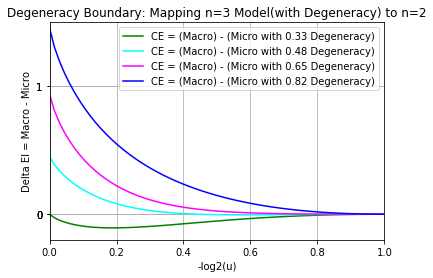

In [20]:
#Plot the EI curve of deterministic n=2 model and n=3 models with the degeneracy that out of the boundary
x = np.linspace(1, 0.5, 51)
savePath = r'D:\Projects\Causal_Emergence\Drafts\Formal Submission\for Hindawi Complexity\Figures_result1'
name = 'Degeneracy_Boundary1.png'
#collect the EI curves of n=3 models
EI_max = collect_Target(3, x)
EI_max[0] = 3
deg_1 = collect_Deg(x, 1, 4) #0.33(boundary)
EI_1 = EI_max - 3 * deg_1 #EI Curves for n=3 models
deg_2 = collect_Deg(x, 1, 5) #0.48
EI_2 = EI_max - 3 * deg_2 #EI Curves for n=3 models
deg_3 = collect_Deg(x, 1, 6) #0.65
EI_3 = EI_max - 3 * deg_3 #EI Curves for n=3 models
deg_4 = collect_Deg(x, 1, 7) #0.82
EI_4 = EI_max - 3 * deg_4 #EI Curves for n=3 models

#Straight lines for the maximum values
initial = np.ones(51)
for j in range(len(initial)):
    initial[j] = EI_1[0]
EI_max_1 = initial
initial = np.ones(51)
for k in range(len(initial)):
    initial[k] = EI_2[0]
EI_max_2 = initial
initial = np.ones(51)
for s in range(len(initial)):
    initial[s] = EI_3[0]
EI_max_3 = initial
initial = np.ones(51)
for p in range(len(initial)):
    initial[p] = EI_4[0]
EI_max_4 = initial
#collect the EI curve of n=2 model
EI_det = collect_Target(2, x)
EI_det[0] = 2

#Plot the Curves and use the straight line to indicate the maximum decreasing of n=3 models
plt.plot(-np.log2(x), EI_det - EI_1, color='green', label = 'CE = (Macro) - (Micro with 0.33 Degeneracy)')
plt.plot(-np.log2(x), EI_det - EI_2, color='cyan', label = 'CE = (Macro) - (Micro with 0.48 Degeneracy)')
plt.plot(-np.log2(x), EI_det - EI_3, color='magenta', label = 'CE = (Macro) - (Micro with 0.65 Degeneracy)')
plt.plot(-np.log2(x), EI_det - EI_4, color='blue', label = 'CE = (Macro) - (Micro with 0.82 Degeneracy)')



plt.xlim(0, 1)
plt.ylim(-0.2, 1.5)
plt.yticks(np.arange(-0.5, 2, 0.5).astype(np.int64))
plt.xlabel("-log2(u)")
plt.ylabel("Delta EI = Macro - Micro")
plt.title('Degeneracy Boundary: Mapping n=3 Model(with Degeneracy) to n=2')
plt.legend()
plt.grid()
plt.savefig(os.path.join(savePath, name))
plt.show()

In [123]:
def degeneracy_boundary(model_size):
    dbs = []
    for value in range(1, model_size):
        db = 1 - value/model_size
        dbs.append(db)
    return dbs

In [124]:
sizes = np.linspace(2, 11, 10)
dbs = {'2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': [], '10': [], '11': []}
for size in sizes:
    dbs[str(int(size))] = degeneracy_boundary(int(size))
print(dbs)

{'2': [0.5], '3': [0.6666666666666667, 0.33333333333333337], '4': [0.75, 0.5, 0.25], '5': [0.8, 0.6, 0.4, 0.19999999999999996], '6': [0.8333333333333334, 0.6666666666666667, 0.5, 0.33333333333333337, 0.16666666666666663], '7': [0.8571428571428572, 0.7142857142857143, 0.5714285714285714, 0.4285714285714286, 0.2857142857142857, 0.1428571428571429], '8': [0.875, 0.75, 0.625, 0.5, 0.375, 0.25, 0.125], '9': [0.8888888888888888, 0.7777777777777778, 0.6666666666666667, 0.5555555555555556, 0.4444444444444444, 0.33333333333333337, 0.2222222222222222, 0.11111111111111116], '10': [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.30000000000000004, 0.19999999999999996, 0.09999999999999998], '11': [0.9090909090909091, 0.8181818181818181, 0.7272727272727273, 0.6363636363636364, 0.5454545454545454, 0.4545454545454546, 0.36363636363636365, 0.2727272727272727, 0.18181818181818177, 0.09090909090909094]}


## Using LinearRegression to fit the generated data

### Data Generation

In [23]:
from tqdm import tqdm
import random as rand
import pandas as pd

#collect the data and save them into a dictionary
data_dict = {'model_size': [], 'uncertainty': [], 'a': [], 'b': [], 'det': [], 'deg': [], 'ei': []}
size = np.linspace(2, 11, 10).astype(np.int32)
uncertainty = np.linspace(1, 0.5, 101)
print(uncertainty)
print(len(uncertainty))
for n in tqdm(size):
    #print(f'size = {n}')
    deg_vector = [1, 1]
    while True:
        if deg_vector[0] != 1 and deg_vector[1] < deg_vector[0]:
            continue
        else:
            future_dg_num = deg_vector[0]
            dg_level = deg_vector[1]
            num_samples = 200
            num_data = 51 * (2 ** n)
            ratio = num_samples / num_data
            for x in uncertainty:
                #print(f'a = {future_dg_num}')
                #print(f'b = {dg_level}')
                if rand.random() < ratio:
                    final_TPMs = retrodict_TPM(n, x, future_dg_num, dg_level)
                    for tpm in final_TPMs:
                        determinism, degeneracy, EI = EI_Calculator(n, tpm)
                        data_dict['model_size'].append(n)
                        data_dict['uncertainty'].append(x)
                        data_dict['a'].append(future_dg_num)
                        data_dict['b'].append(dg_level)
                        data_dict['det'].append(determinism)
                        data_dict['deg'].append(degeneracy)
                        data_dict['ei'].append(EI)
        if deg_vector[1] == 2 ** n:
            break
        else:
            deg_vector[1] += 1

[1.    0.995 0.99  0.985 0.98  0.975 0.97  0.965 0.96  0.955 0.95  0.945
 0.94  0.935 0.93  0.925 0.92  0.915 0.91  0.905 0.9   0.895 0.89  0.885
 0.88  0.875 0.87  0.865 0.86  0.855 0.85  0.845 0.84  0.835 0.83  0.825
 0.82  0.815 0.81  0.805 0.8   0.795 0.79  0.785 0.78  0.775 0.77  0.765
 0.76  0.755 0.75  0.745 0.74  0.735 0.73  0.725 0.72  0.715 0.71  0.705
 0.7   0.695 0.69  0.685 0.68  0.675 0.67  0.665 0.66  0.655 0.65  0.645
 0.64  0.635 0.63  0.625 0.62  0.615 0.61  0.605 0.6   0.595 0.59  0.585
 0.58  0.575 0.57  0.565 0.56  0.555 0.55  0.545 0.54  0.535 0.53  0.525
 0.52  0.515 0.51  0.505 0.5  ]
101


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [41:31<00:00, 249.18s/it]


### Training the LinearRegression algorithm by data from each size of TPM

In [9]:
from sklearn.linear_model import LinearRegression
model_dict = {'size': [], 'model': []}
for n in tqdm(size):
    feature_x  = []
    feature_ei = []
    for i in range(len(data_dict['model_size'])):
        if data_dict['model_size'][i] == n:
            feature_x.append(data_dict['uncertainty'][i])
            feature_ei.append(data_dict['ei'][i])
    print(f'when the model size is {n}, there are {len(feature_ei)} samples')
    length = len(feature_ei)
    sizes = [n] * length
    X = list(zip(sizes, feature_ei))
    model = LinearRegression()
    model.fit(X, feature_x)
    model_dict['size'].append(n)
    model_dict['model'].append(model)
print(f'finally, models for each model size are\n{model_dict}')

NameError: name 'tqdm' is not defined

### LinearRegression predicts the values of uncertainties by giving TPM sizes and corresponding EIs

In [105]:
test_data = [[2, 1], [3, 1], [4, 1], [5, 1], [6, 1], [7, 1], [8, 1], [9, 1], [10, 1], [11, 1]]  # the group of the pairs of sizes and EIs

predictions = []
for data in test_data:
    for i in range(len(model_dict['size'])):
        if model_dict['size'][i] == data[0]:
            model = model_dict['model'][i]
    prediction = model.predict([data])
    predictions.append(-np.log2(prediction))
print(predictions)

[array([0.13896431]), array([0.25838377]), array([0.33469725]), array([0.38703179]), array([0.4204336]), array([0.45348072]), array([0.46818338]), array([0.47867807]), array([0.48808659]), array([0.49842033])]
